In [1]:
import pandas as pd
import numpy as np

# Загрузка данных
data = pd.read_csv('real_estate_data.csv')

# Просмотр первых строк и информации о данных
print(data.head())
print(data.info())

      Neighborhood                     Type     Price  Beds  Baths  \
0   Inner Richmond  Single Family Residence    888000   3.0      1   
1     Outer Sunset  Single Family Residence    995000   2.0      1   
2  Pacific Heights  Single Family Residence  32000000   4.0     10   
3  Dolores Heights              Condominium   1095000   3.0      1   
4  Mission Dolores              Condominium    849000   3.0      2   

   Built Year   Longitude   Latitude  \
0      1911.0 -122.475296  37.779910   
1      1926.0 -122.493380  37.761646   
2      1987.0 -122.446290  37.793170   
3         NaN -122.428910  37.754200   
4      1890.0 -122.427880  37.763150   

                                                Link  
0  https://www.zillow.com/homedetails/427-16th-Av...  
1  https://www.zillow.com/homedetails/1367-34th-A...  
2  https://www.zillow.com/homedetails/2990-Broadw...  
3  https://www.zillow.com/homedetails/22-Vicksbur...  
4  https://www.zillow.com/homedetails/3670-17th-S...  
<class '

In [2]:
# Удаление строк с пропущенными значениями в ключевых столбцах
data.dropna(subset=['Beds', 'Baths', 'Built Year'], inplace=True)

# Преобразование типов данных
data['Beds'] = data['Beds'].astype(int)
data['Baths'] = data['Baths'].astype(int)
data['Built Year'] = data['Built Year'].astype(int)

# Удаление ненужных столбцов
data.drop(columns=['Link'], inplace=True)

# Обработка выбросов в признаке 'Price'
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['Price'] < (Q1 - 1.5 * IQR)) | (data['Price'] > (Q3 + 1.5 * IQR)))]

In [3]:
from sklearn.preprocessing import LabelEncoder

# Преобразование категориальных переменных
label_encoder = LabelEncoder()
data['Neighborhood'] = label_encoder.fit_transform(data['Neighborhood'])
data['Type'] = label_encoder.fit_transform(data['Type'])

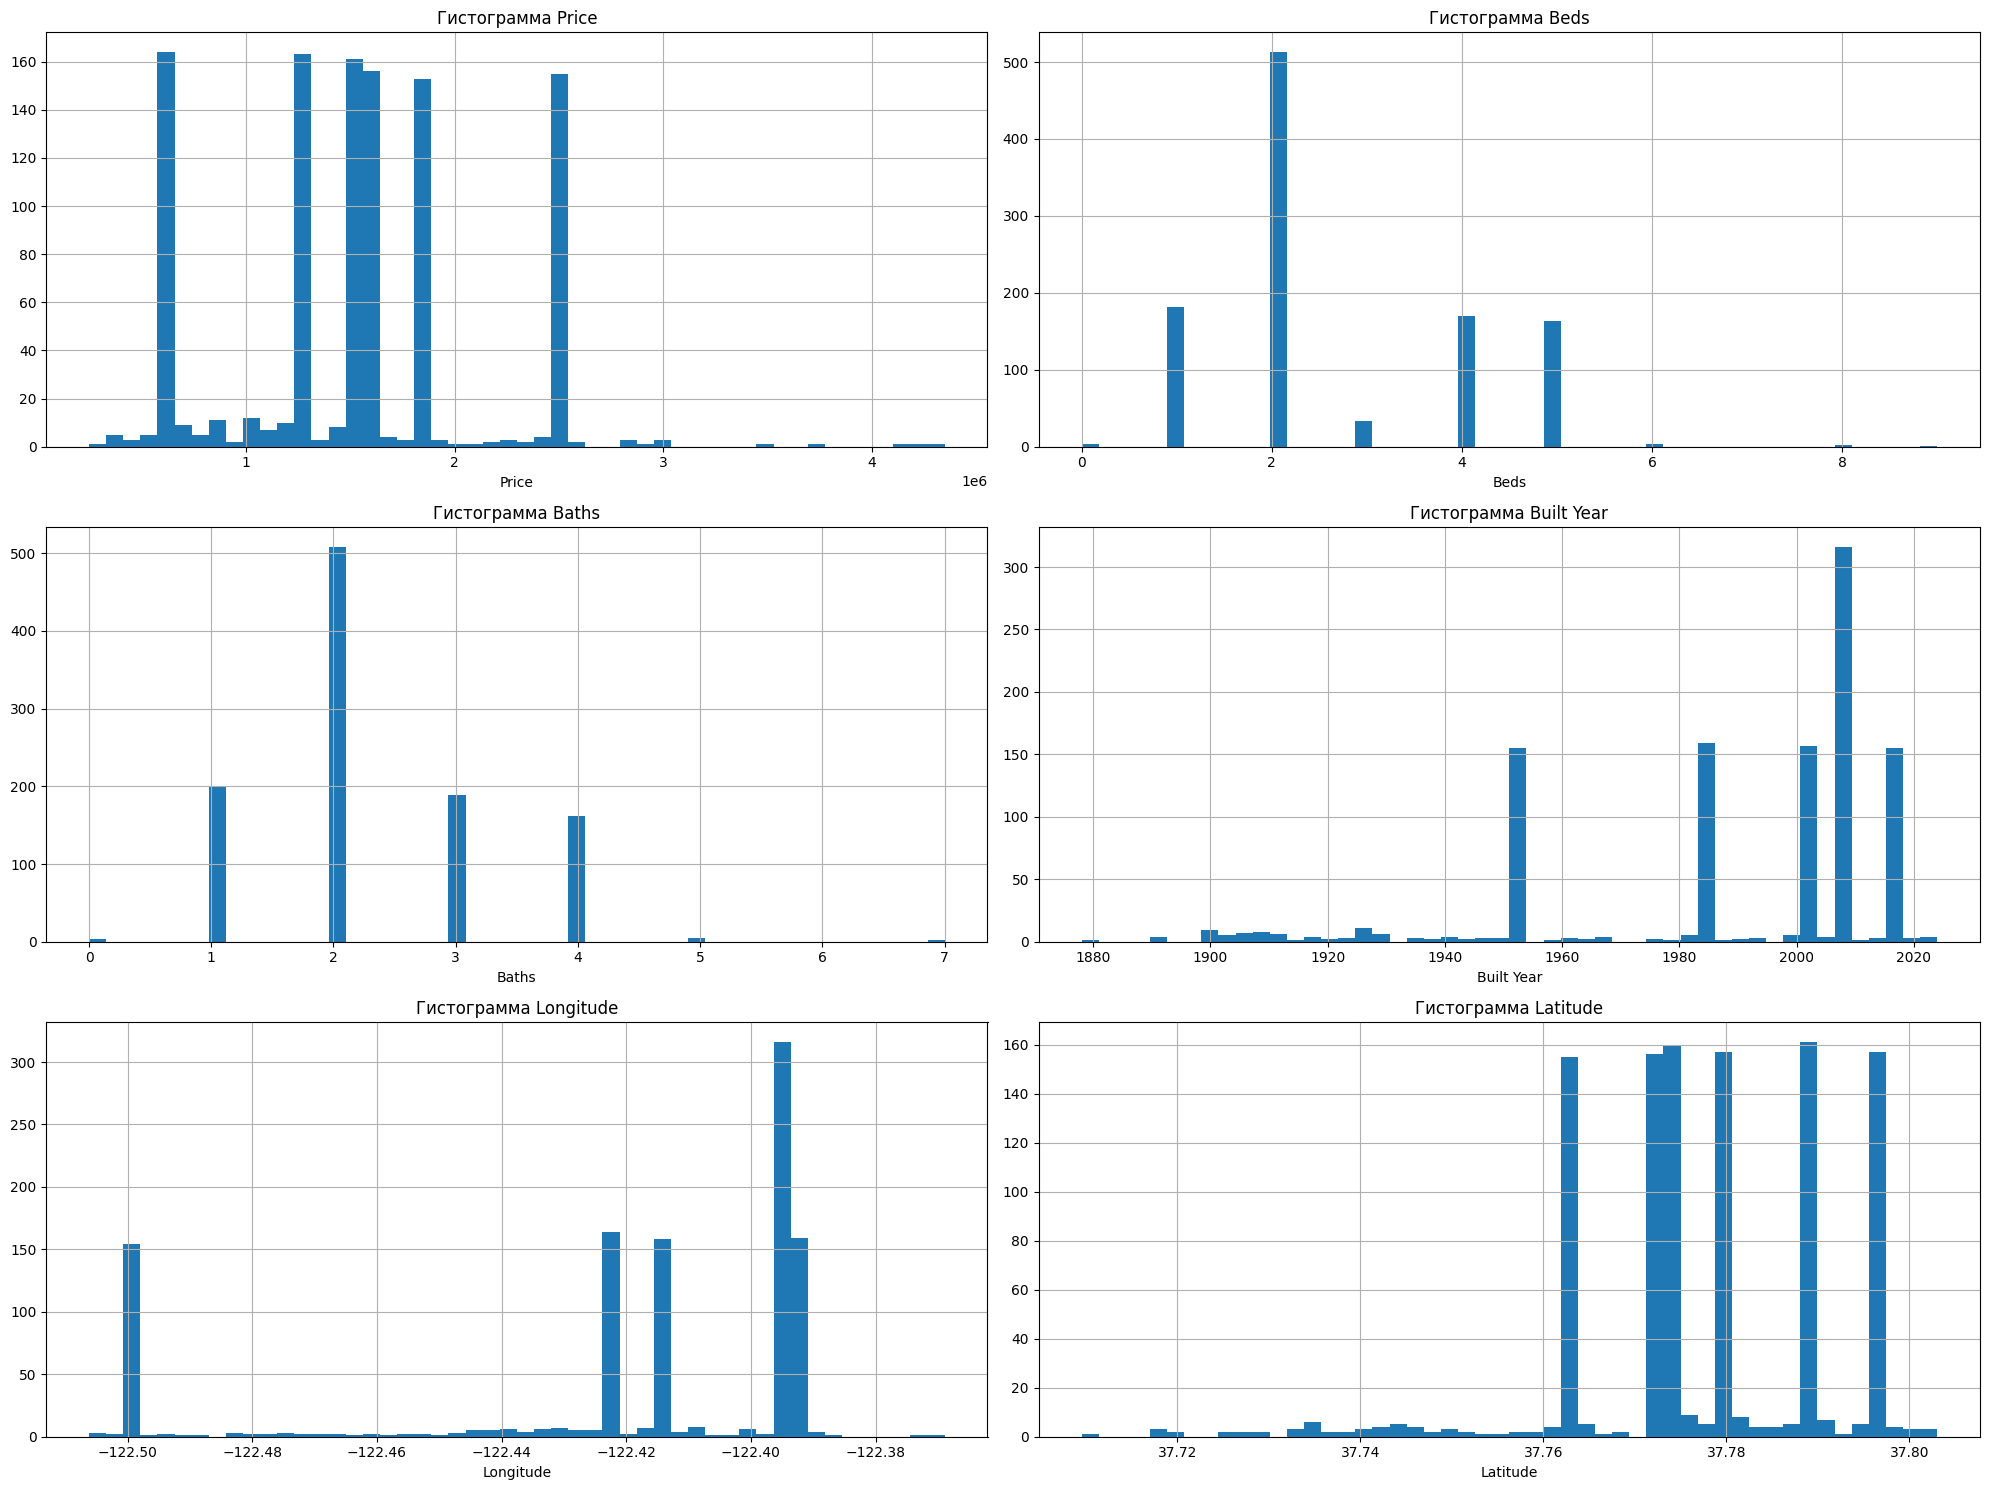

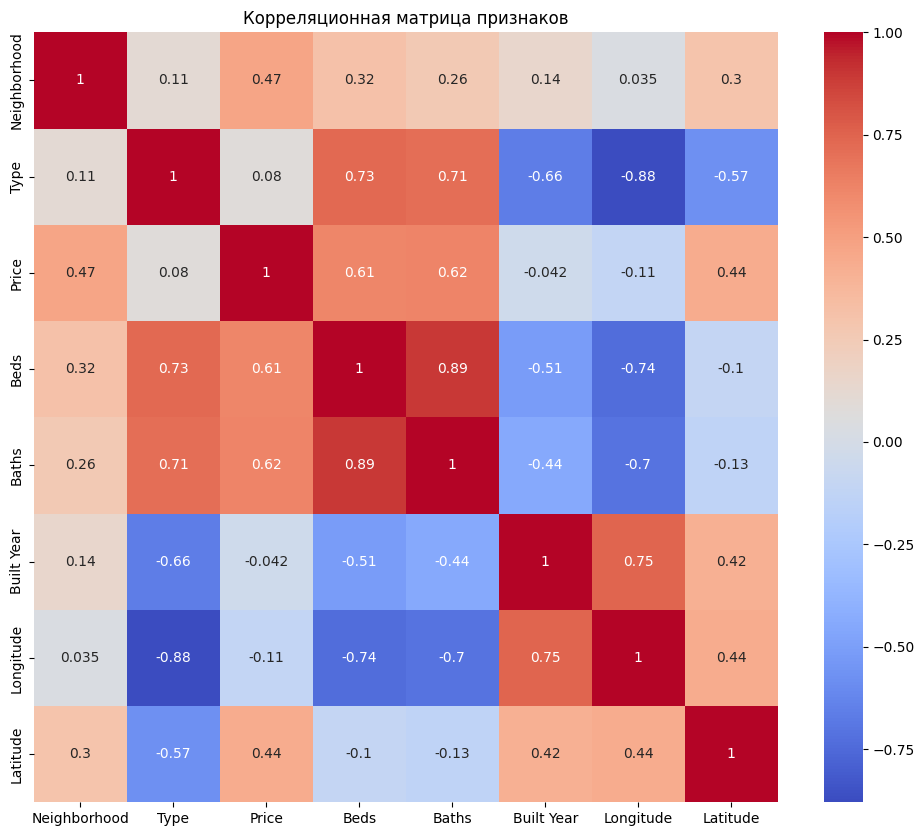

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Гистограммы для числовых признаков
plt.figure(figsize=(20, 15))
for i, column in enumerate(['Price', 'Beds', 'Baths', 'Built Year', 'Longitude', 'Latitude'], 1):
    plt.subplot(3, 2, i)
    data[column].hist(bins=50)
    plt.title(f'Гистограмма {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

# Корреляционная матрица
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица признаков')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Price'])
y = data['Price']

# Разделение данных
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

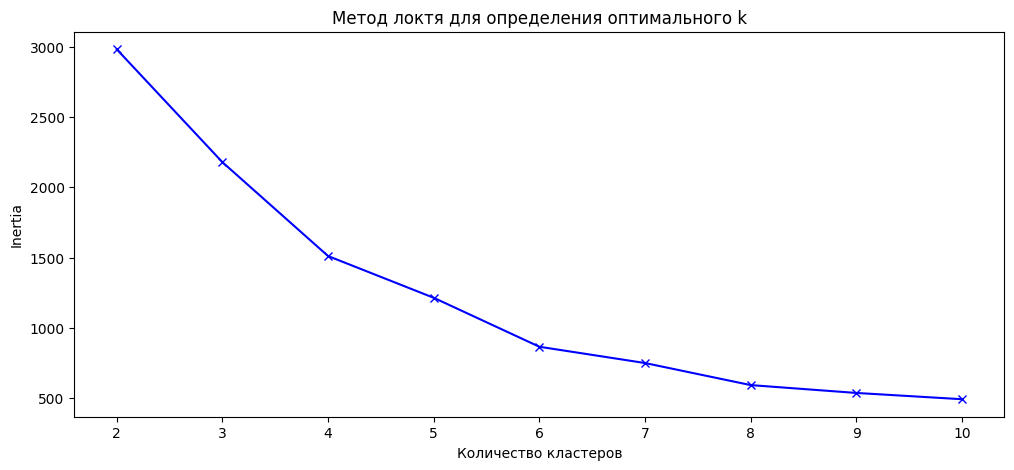

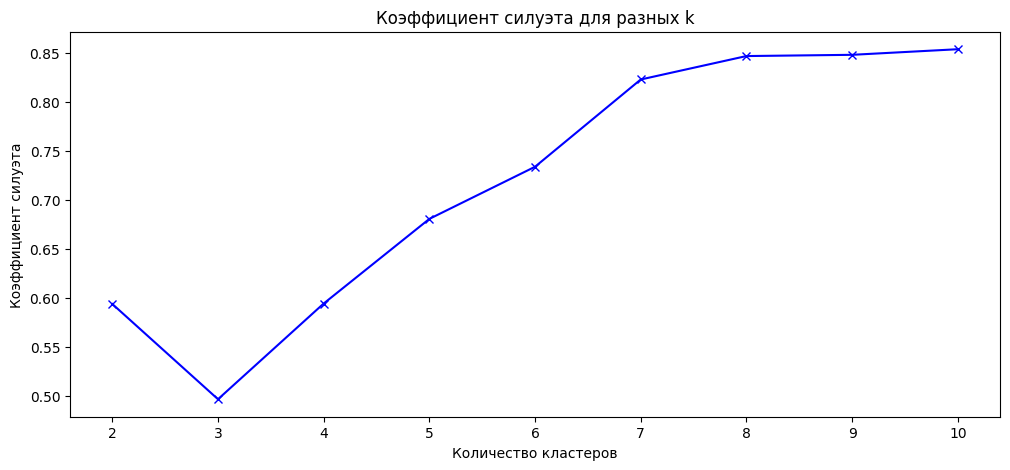

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Метод локтя
plt.figure(figsize=(12, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального k')
plt.show()

# Коэффициент силуэта
plt.figure(figsize=(12, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.title('Коэффициент силуэта для разных k')
plt.show()

In [8]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_train_scaled)
train_labels = kmeans.labels_

# Применение модели к тестовым данным
test_labels = kmeans.predict(X_test_scaled)

In [9]:
# Коэффициент силуэта для обучающих данных
silhouette_avg = silhouette_score(X_train_scaled, train_labels)
print(f'Средний коэффициент силуэта для обучающей выборки: {silhouette_avg}')

# Коэффициент силуэта для тестовых данных
silhouette_avg_test = silhouette_score(X_test_scaled, test_labels)
print(f'Средний коэффициент силуэта для тестовой выборки: {silhouette_avg_test}')

Средний коэффициент силуэта для обучающей выборки: 0.4967139684035349
Средний коэффициент силуэта для тестовой выборки: 0.5011266416796855


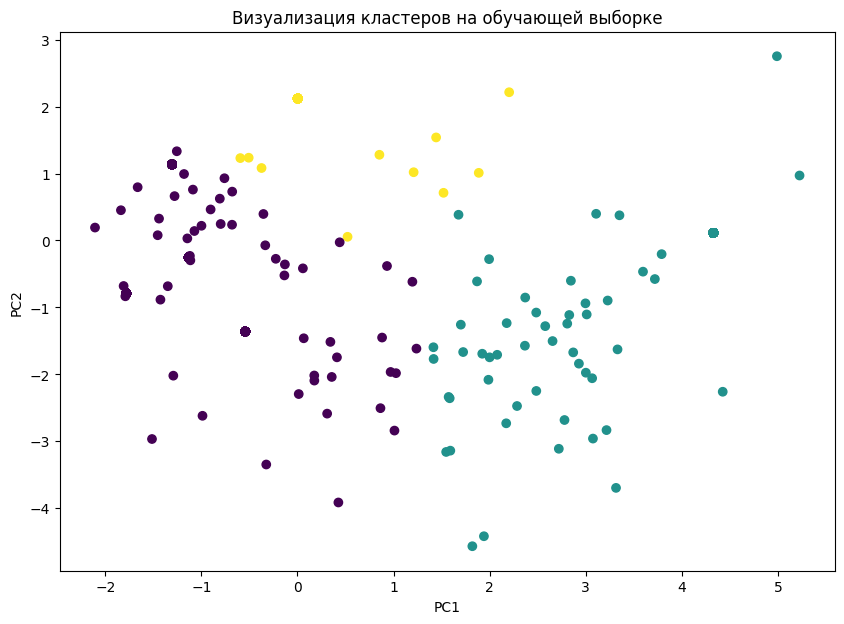

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_labels, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Визуализация кластеров на обучающей выборке')
plt.show()

In [11]:
import numpy as np

class CustomKMeans:
    def __init__(self, clusters=3, iterations=300, tolerance=1e-4, initialization='random'):
        self.clusters = clusters
        self.iterations = iterations
        self.tolerance = tolerance
        self.initialization = initialization

    def fit(self, data):
        np.random.seed(42)

        if self.initialization == 'random':
            self.centroids = data[np.random.choice(data.shape[0], self.clusters, replace=False)]
        elif self.initialization == 'k-means++':
            self.centroids = self._initialize_centroids_plus(data)
        else:
            raise ValueError("Invalid initialization method.")

        for iteration in range(self.iterations):
            distances = self._calculate_distances(data)
            labels = np.argmin(distances, axis=1)

            updated_centroids = np.array([data[labels == idx].mean(axis=0) if np.any(labels == idx) else self.centroids[idx] 
                                           for idx in range(self.clusters)])

            centroid_shift = np.linalg.norm(self.centroids - updated_centroids)
            if centroid_shift < self.tolerance:
                break

            self.centroids = updated_centroids

        self.labels_ = labels

    def _calculate_distances(self, data):
        return np.sqrt(((data[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))

    def _initialize_centroids_plus(self, data):
        centroids = [data[np.random.randint(data.shape[0])]]
        for _ in range(1, self.clusters):
            distances = np.min([np.linalg.norm(data - center, axis=1) for center in centroids], axis=0)
            probabilities = distances / distances.sum()
            cumulative_distribution = np.cumsum(probabilities)
            random_value = np.random.rand()
            next_centroid = data[np.where(cumulative_distribution >= random_value)[0][0]]
            centroids.append(next_centroid)
        return np.array(centroids)

    def predict(self, data):
        distances = self._calculate_distances(data)
        return np.argmin(distances, axis=1)

In [12]:
# Обучение модели
custom_kmeans = CustomKMeans(clusters=optimal_k, iterations=300, tolerance=1e-4, initialization='k-means++')
custom_kmeans.fit(X_train_scaled)

custom_train_labels = custom_kmeans.labels_

custom_test_labels = custom_kmeans.predict(X_test_scaled)

custom_silhouette_train = silhouette_score(X_train_scaled, custom_train_labels)
custom_silhouette_test = silhouette_score(X_test_scaled, custom_test_labels)

print(f'Коэффициент силуэта для обучающей выборки (Custom): {custom_silhouette_train:.4f}')
print(f'Коэффициент силуэта для тестовой выборки (Custom): {custom_silhouette_test:.4f}')

Коэффициент силуэта для обучающей выборки (Custom): 0.5198
Коэффициент силуэта для тестовой выборки (Custom): 0.5278


In [13]:
print("Сравнение коэффициентов силуэта:")
print(f"Sklearn KMeans - Обучающая выборка: {silhouette_avg}, Тестовая выборка: {silhouette_avg_test}")
print(f"Custom KMeans - Обучающая выборка: {custom_silhouette_train}, Тестовая выборка: {custom_silhouette_test}")

Сравнение коэффициентов силуэта:
Sklearn KMeans - Обучающая выборка: 0.4967139684035349, Тестовая выборка: 0.5011266416796855
Custom KMeans - Обучающая выборка: 0.5197918442592853, Тестовая выборка: 0.5277651101457482


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


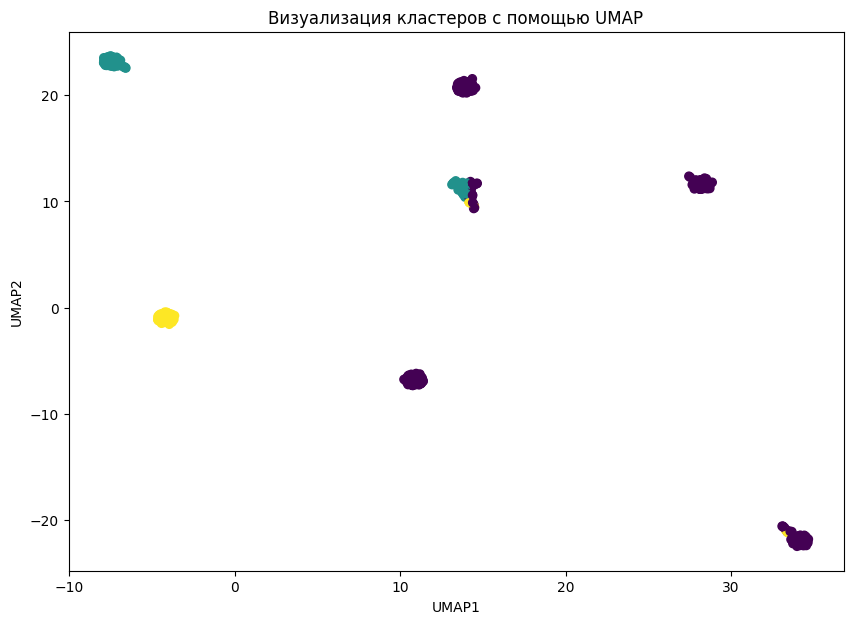

In [14]:
import umap

reducer = umap.UMAP(random_state=42)
X_train_umap = reducer.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=train_labels, cmap='viridis')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('Визуализация кластеров с помощью UMAP')
plt.show()